In [1]:
import sys
sys.path.insert(1,'../src')

import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf, acf
import matplotlib.pyplot as plt
import warnings
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima_model import ARIMA

plt.rcParams.update({'figure.figsize':(16, 8), 'figure.dpi':300})
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data/prices250.csv")
ParamDict = {}

In [3]:
def get_parameter(df):
    # find order of differencing
    d = ndiffs(df, test='adf')
    
    # differencing
    differenced = df
    for i in range(d):
        differenced = differenced.diff()
    differenced = differenced.dropna()
    
    # AR term
    coef = pacf(differenced)
    level = np.exp(2 * 1.96 / np.sqrt(len(differenced) - 3) - 1) / np.exp(2 * 1.96 / np.sqrt(len(differenced) - 3) + 1)
    
    a = coef > level
    p = len(np.split(a, np.where(a != 1)[0])[0]) - 1
    
    # MA term
    coef = acf(differenced)
    
    a = coef > level
    q = len(np.split(a, np.where(a != 1)[0])[0]) - 1
    return p, d, q

In [4]:
for i in df.columns:
    ParamDict[i] = get_parameter(df[i])

In [5]:
filtered_dict = {key:value for key, value in ParamDict.items() if (value[0] > 0) & (value[2] > 0)}
model_dict = {}

In [6]:
filtered_dict

{'3': (1, 0, 37),
 '10': (1, 1, 1),
 '13': (1, 0, 40),
 '43': (1, 1, 1),
 '46': (1, 0, 34),
 '47': (1, 0, 40),
 '56': (3, 0, 15),
 '59': (5, 0, 13),
 '62': (3, 0, 7),
 '66': (4, 0, 25),
 '67': (3, 0, 19),
 '69': (3, 0, 40),
 '70': (4, 0, 10),
 '73': (4, 0, 25),
 '74': (2, 0, 3),
 '77': (5, 0, 32),
 '80': (4, 0, 26),
 '81': (2, 0, 13),
 '84': (2, 0, 15),
 '89': (4, 0, 20),
 '90': (4, 0, 12),
 '92': (5, 0, 15),
 '93': (4, 0, 13),
 '95': (4, 0, 13),
 '96': (3, 0, 5),
 '98': (3, 0, 40),
 '99': (3, 0, 18)}

In [7]:
for key in filtered_dict.keys():
    order = filtered_dict[key]
    model = ARIMA(df[key], order=(order[0], order[1], 1)) # only use 1 ma term
    try:
        model_fit = model.fit(disp=0)
        print("%s has been fitted" % key)
        model_dict[key] = model_fit
    except:
        print("%s cannot be done" % key)

3 has been fitted
10 has been fitted
13 has been fitted
43 has been fitted
46 has been fitted
47 has been fitted
56 has been fitted
59 has been fitted
62 has been fitted
66 has been fitted
67 has been fitted
69 has been fitted
70 has been fitted
73 has been fitted
74 has been fitted
77 has been fitted
80 has been fitted
81 has been fitted
84 has been fitted
89 has been fitted
90 has been fitted
92 has been fitted
93 has been fitted
95 cannot be done
96 has been fitted
98 has been fitted
99 has been fitted


                              ARMA Model Results                              
Dep. Variable:                     99   No. Observations:                  230
Model:                     ARMA(3, 1)   Log Likelihood                 273.411
Method:                       css-mle   S.D. of innovations              0.074
Date:                Sat, 03 Jul 2021   AIC                           -534.822
Time:                        16:49:28   BIC                           -514.194
Sample:                             0   HQIC                          -526.501
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6007      0.021    122.488      0.000       2.559       2.642
ar.L1.99       0.8537      0.253      3.373      0.001       0.358       1.350
ar.L2.99      -0.0140      0.115     -0.122      0.9

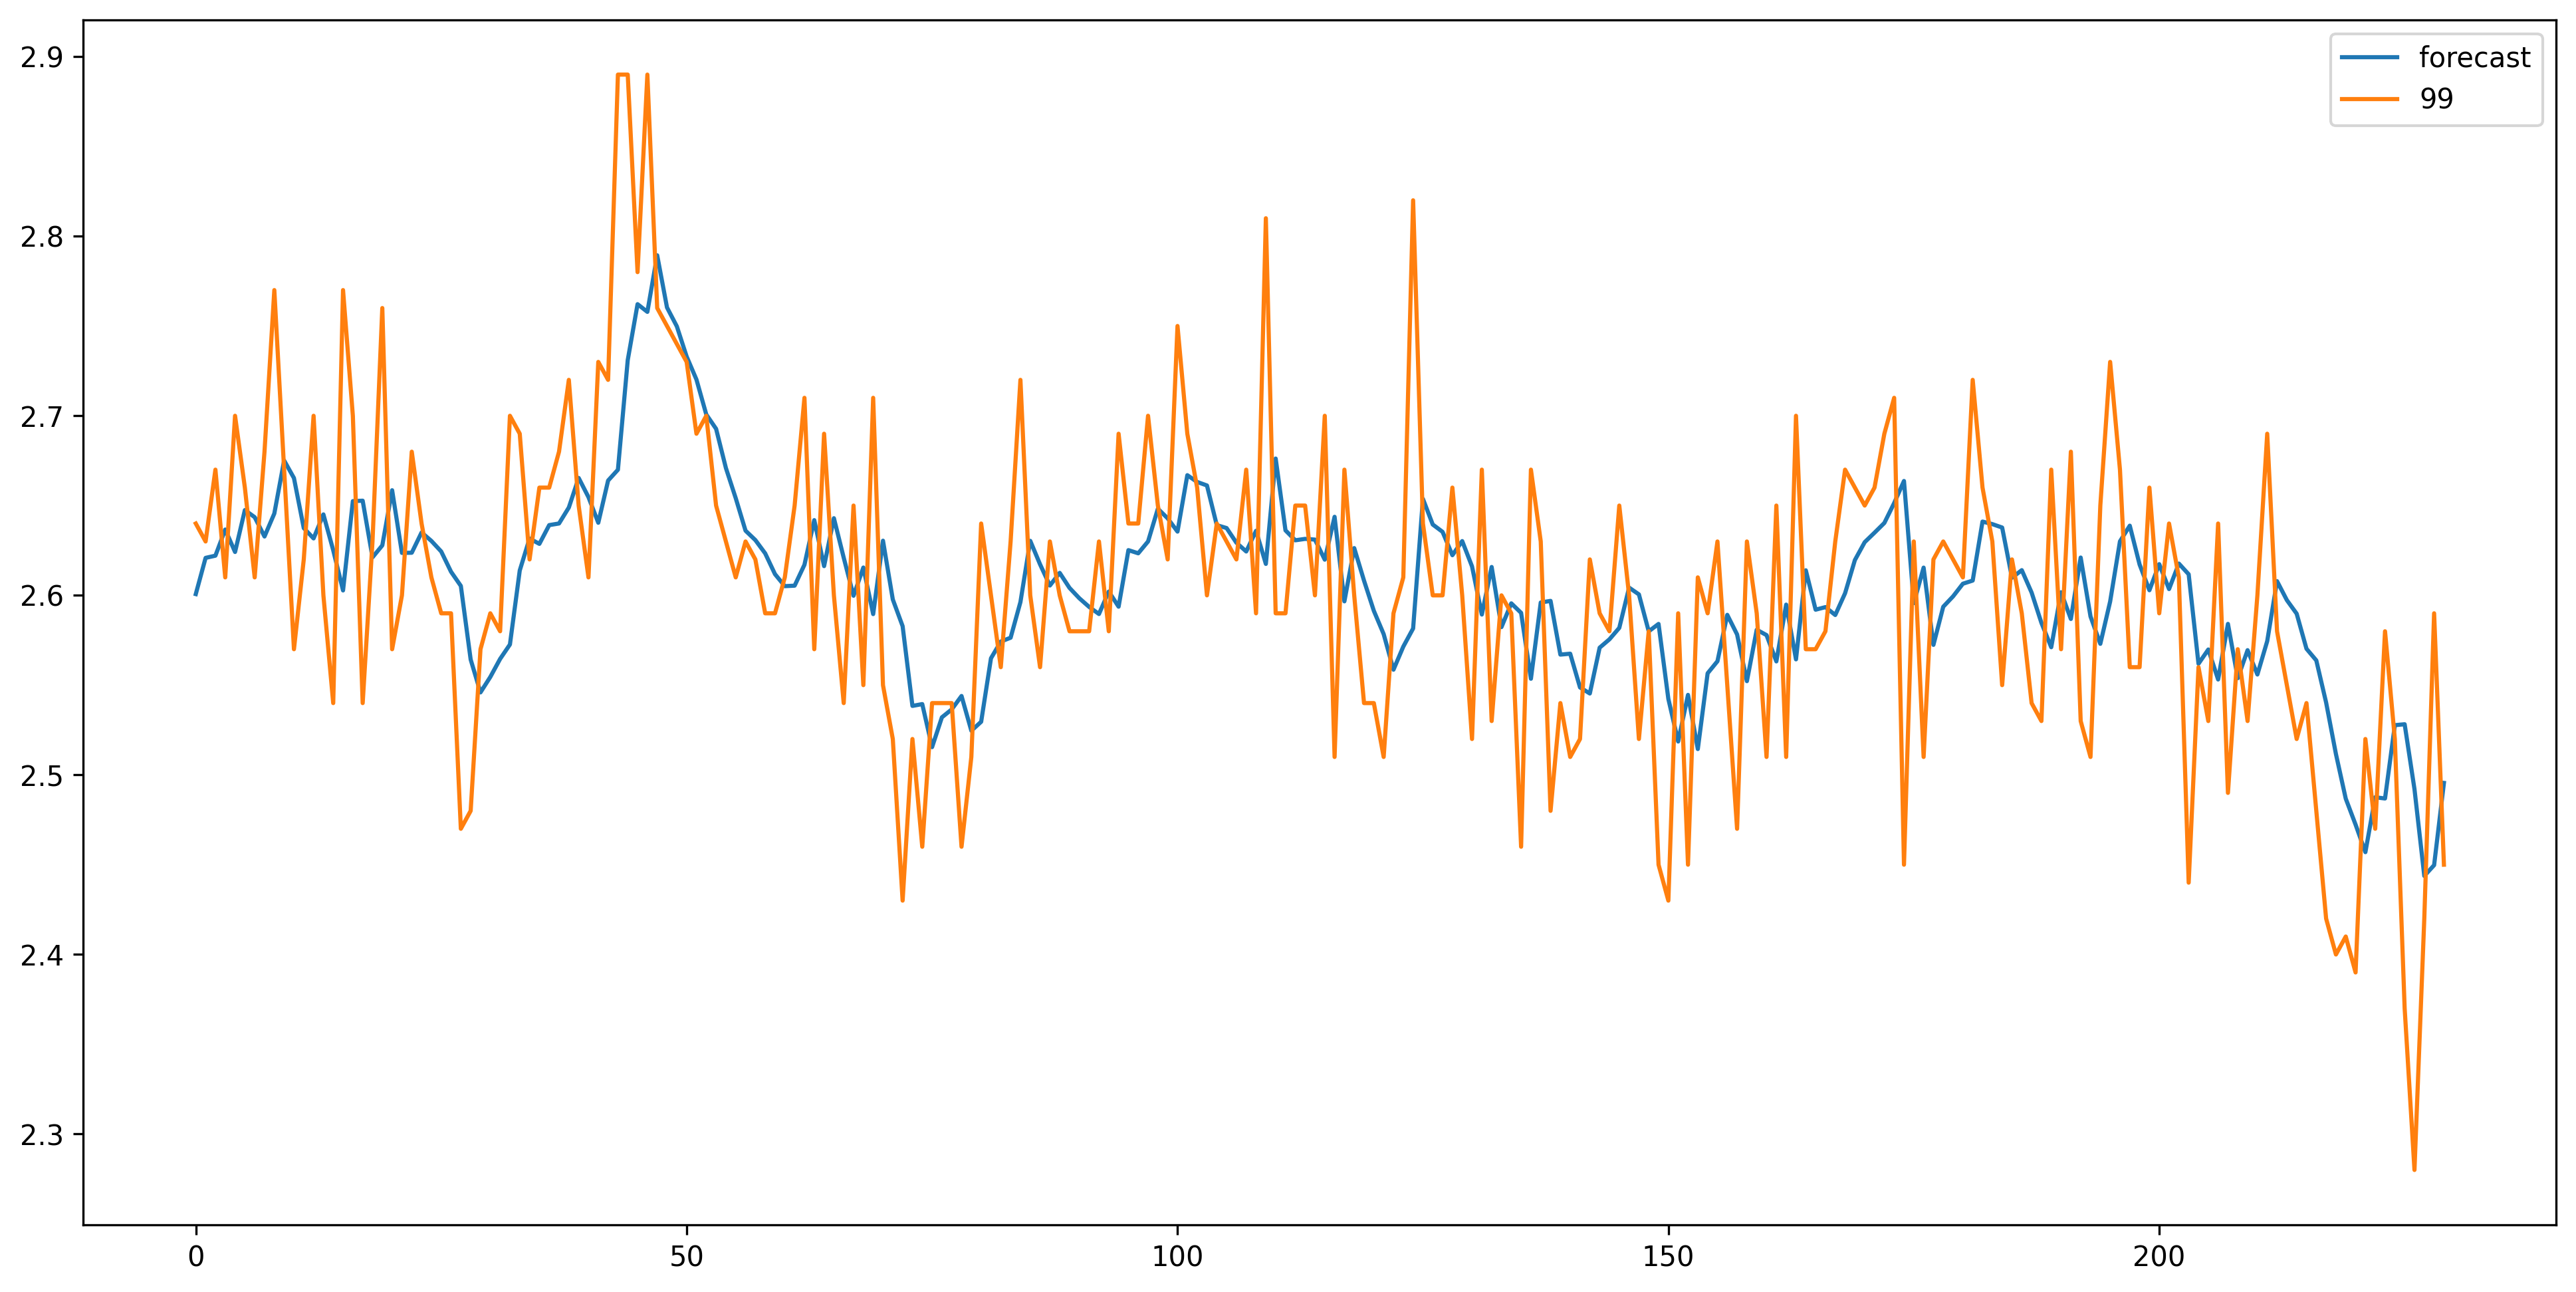

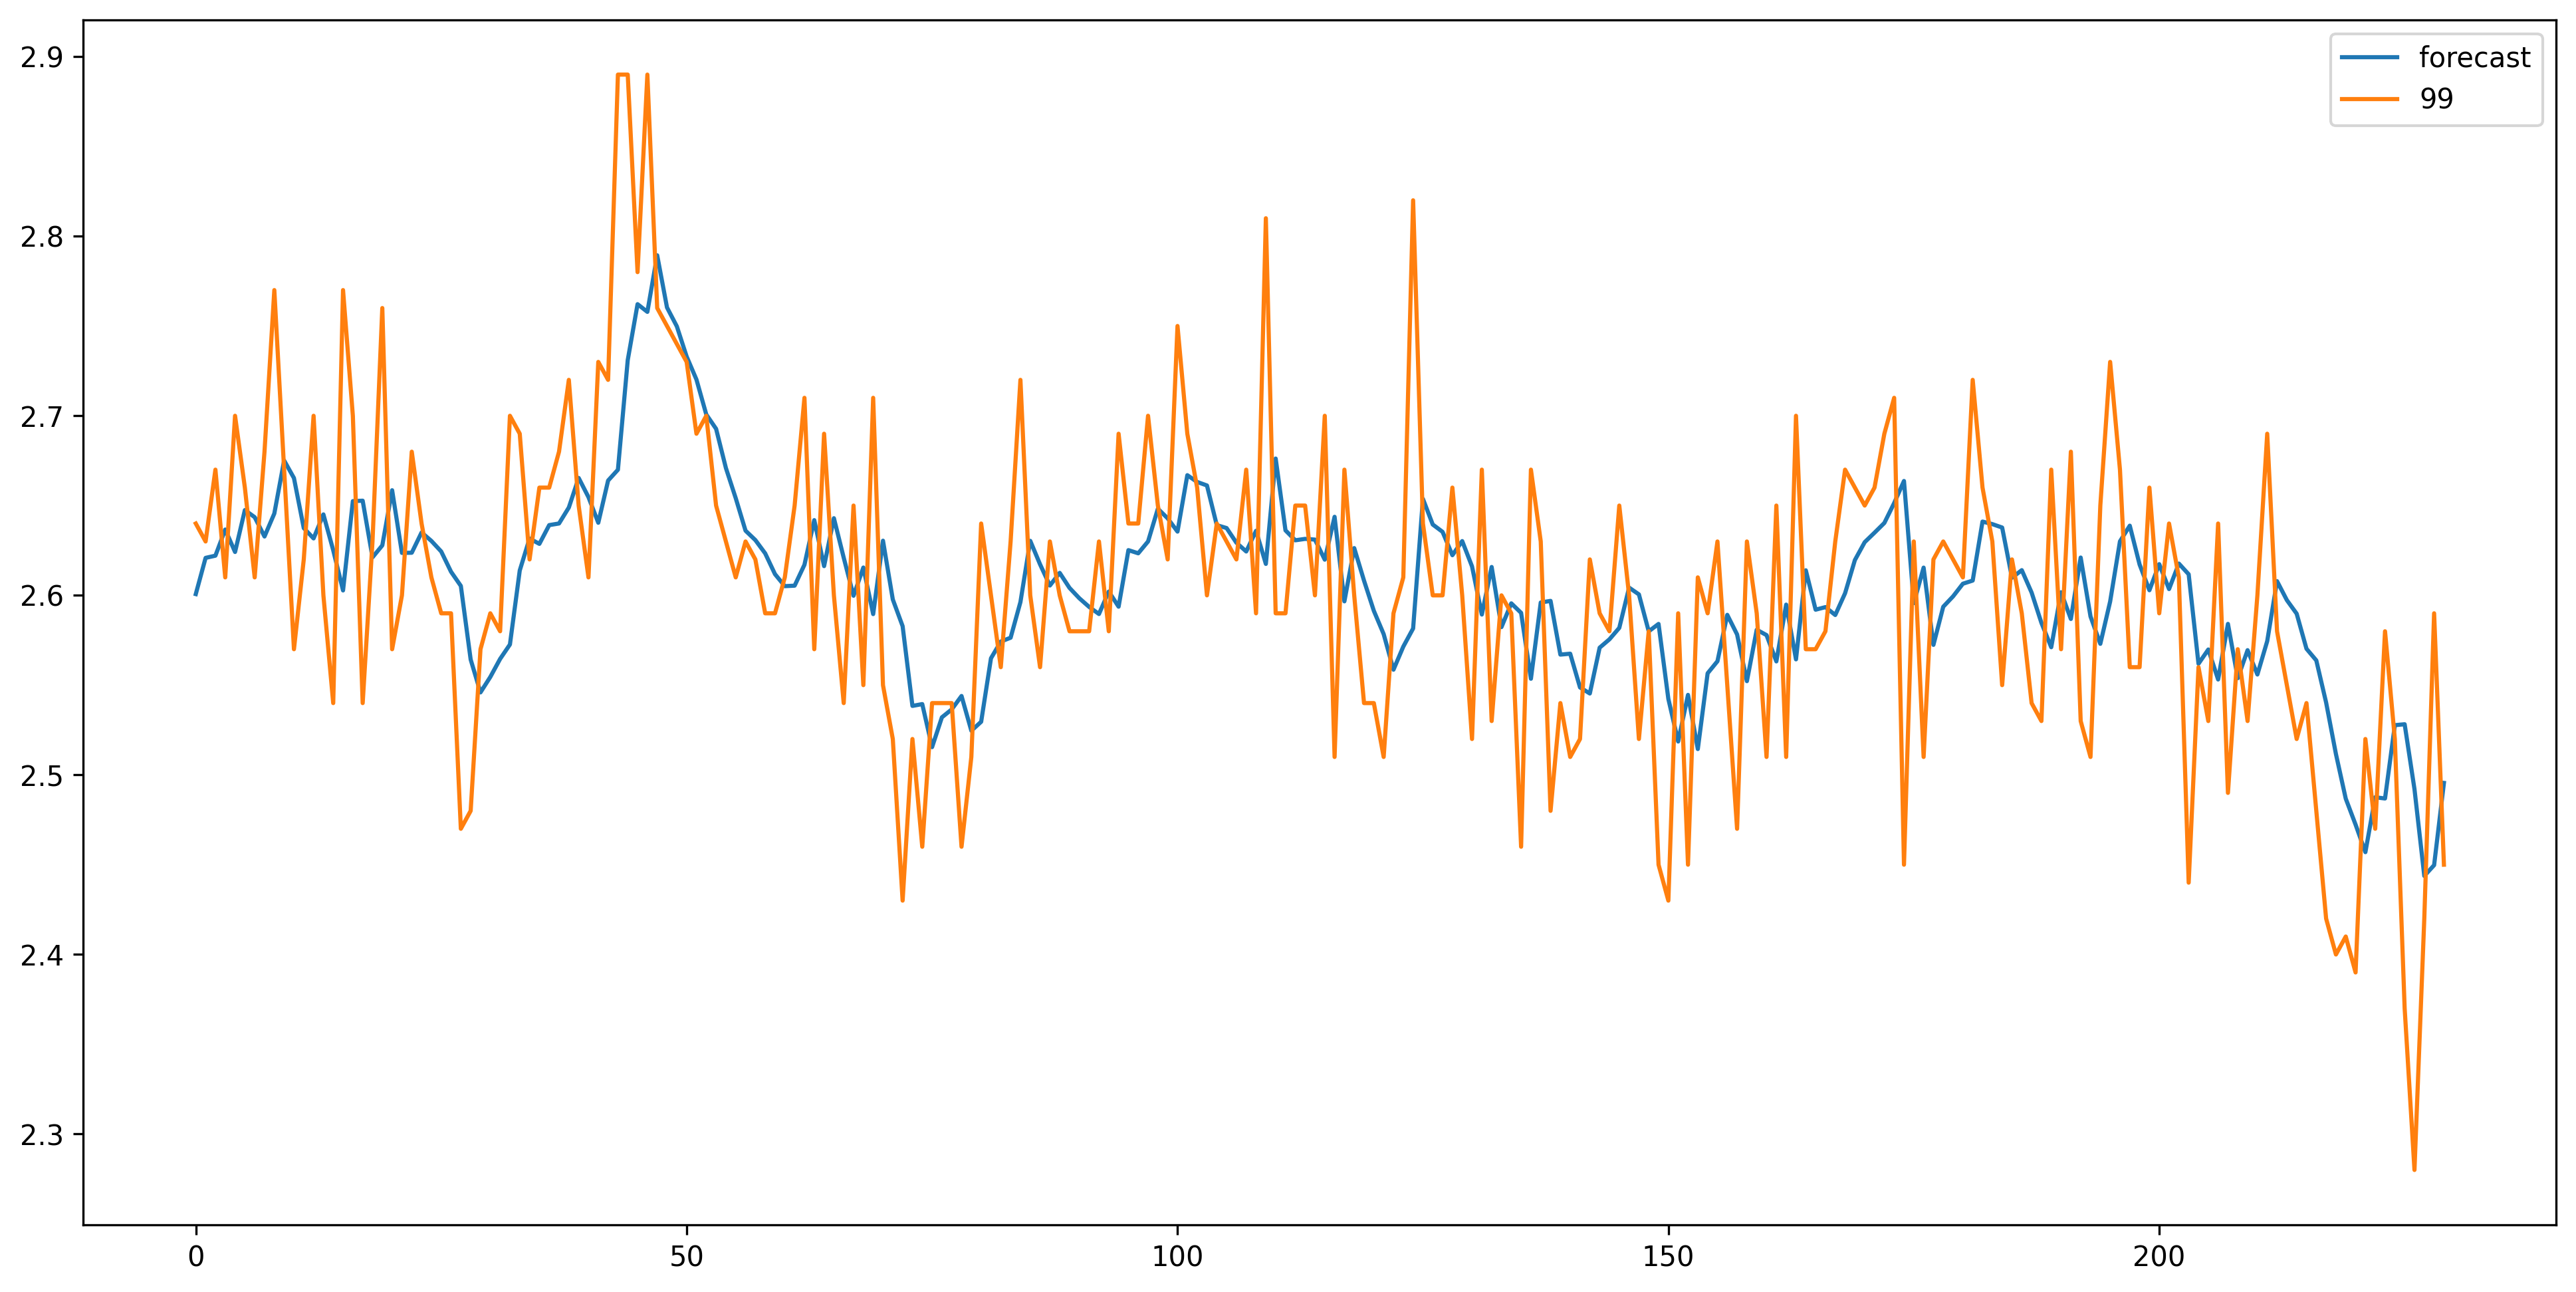

In [24]:
key = '99'
order = filtered_dict[key]
model = ARIMA(df[key][:230], order=(order[0], order[1], 1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
model_fit.plot_predict(dynamic=False)

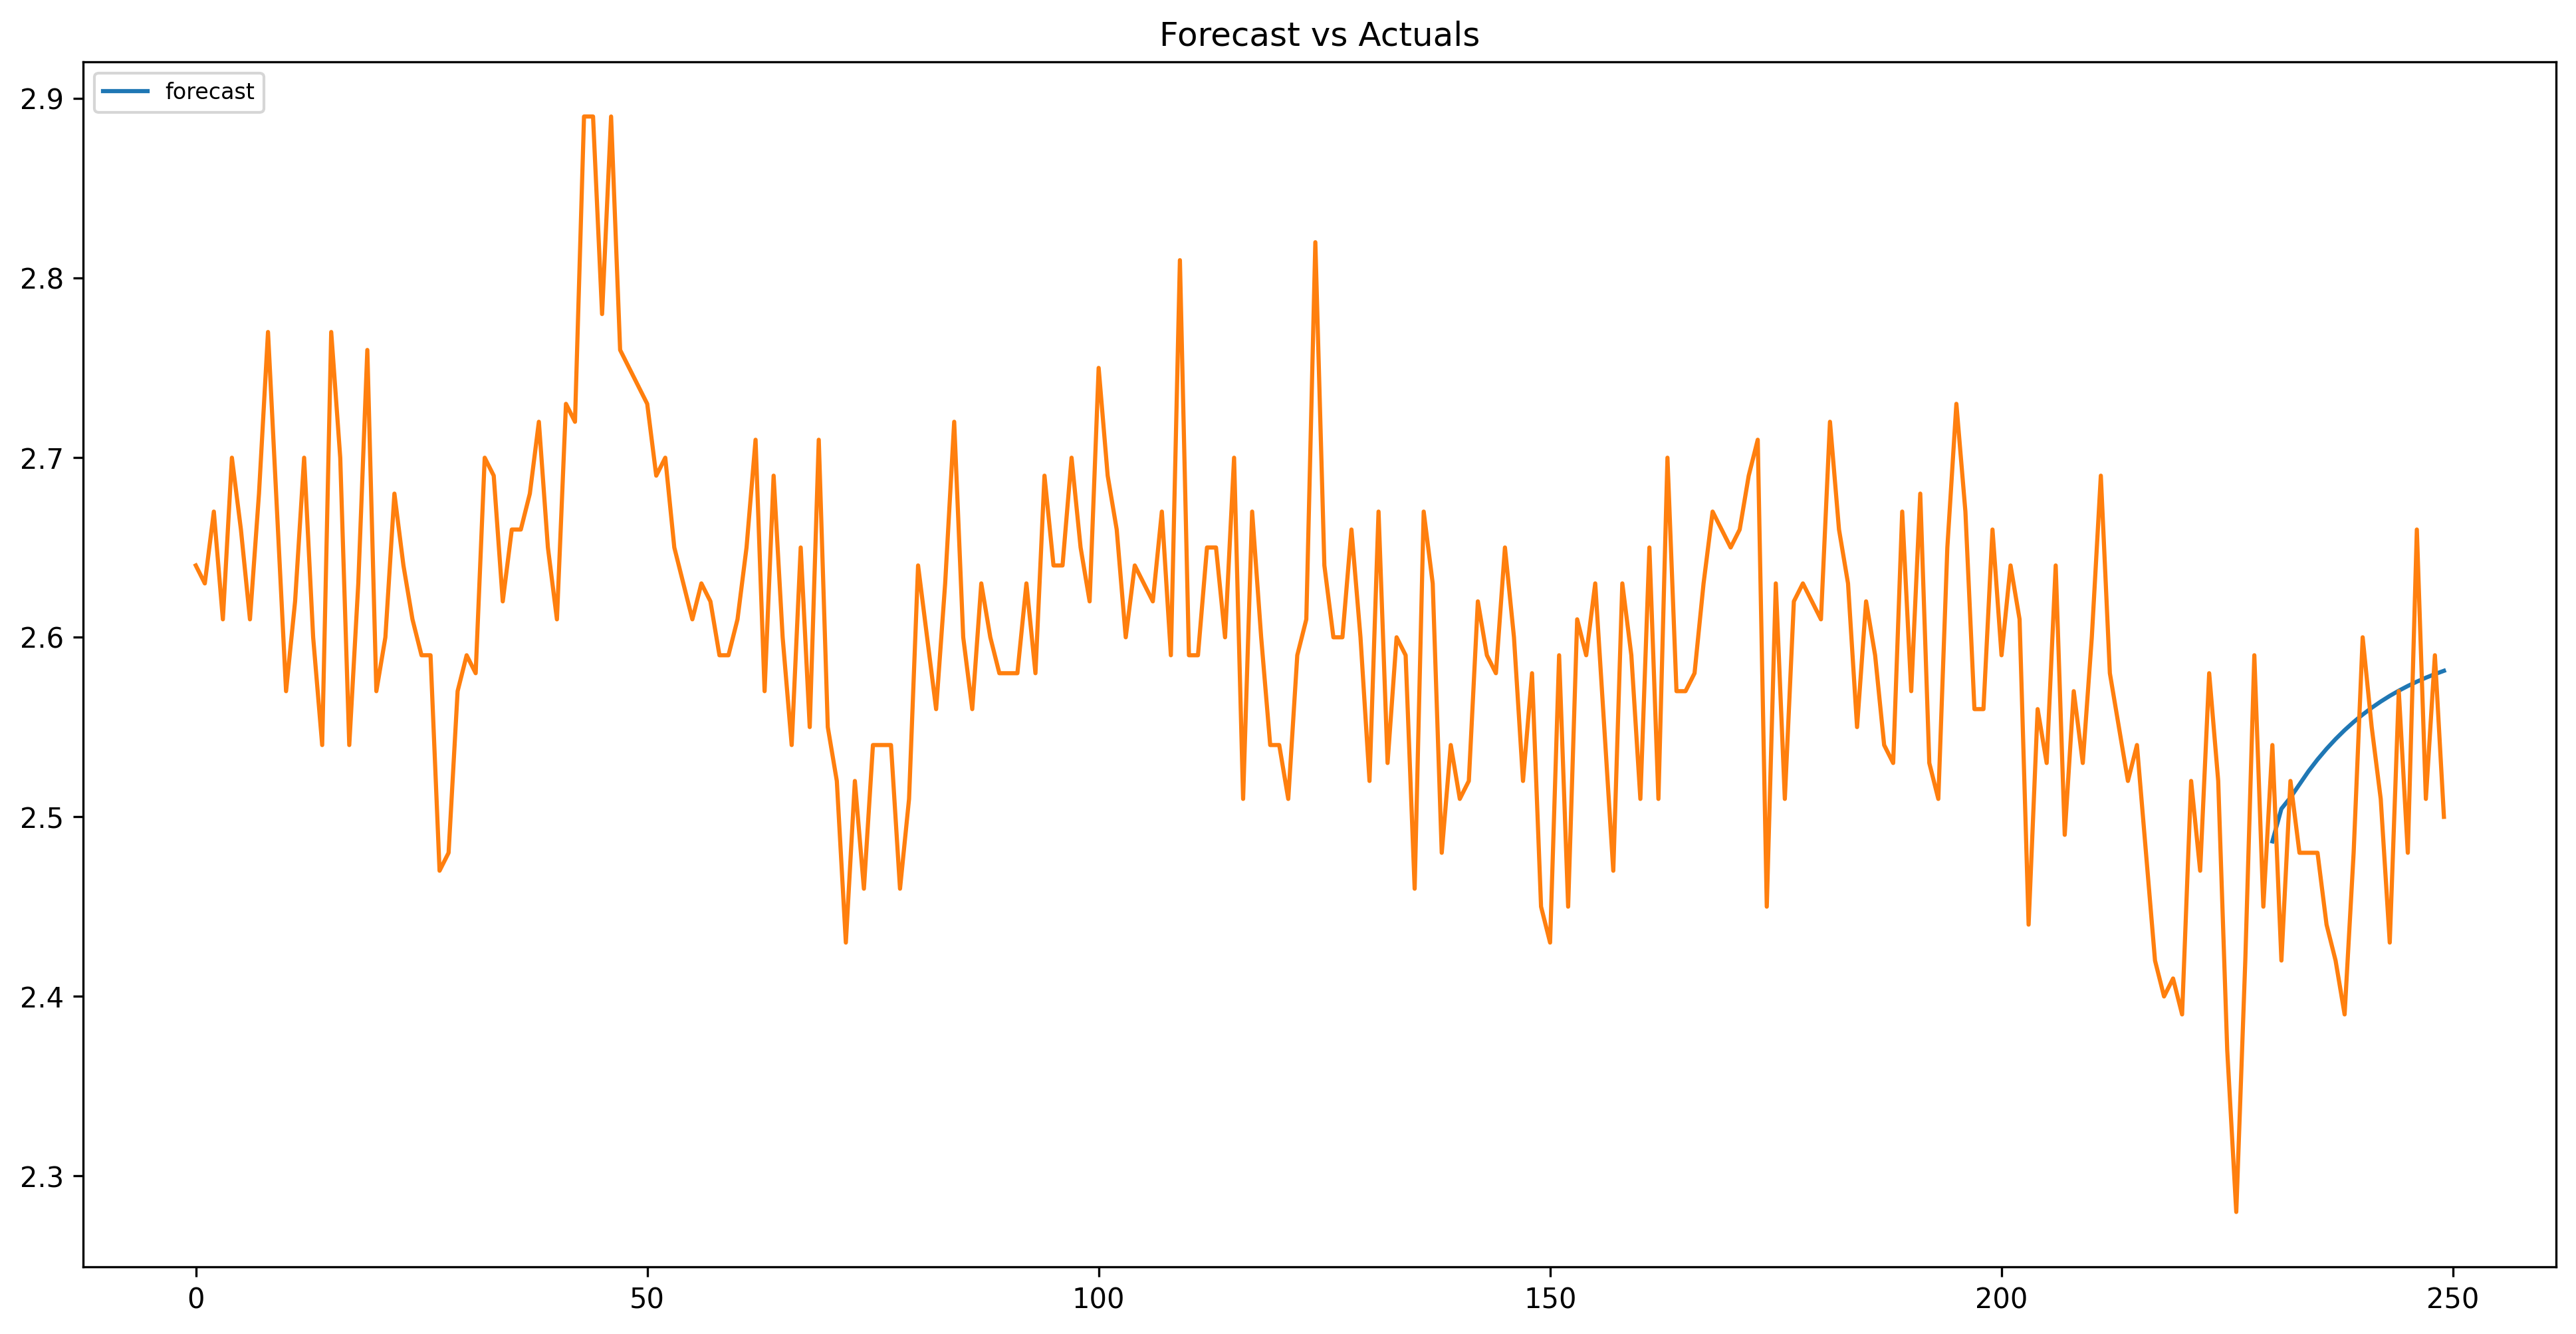

In [25]:
fc, se, conf = model_fit.forecast(20, alpha=0.05)  # 95% conf
plt.plot(range(230, 250), fc, label='forecast')
plt.plot(df[key])
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()